# Diabetes Detection using Artificial Neural Network (ANN)

In this notebook, we build an Artificial Neural Network (ANN) model using **TensorFlow and Keras** to predict diabetes based on clinical attributes.

We'll follow these steps:
1. Import libraries  
2. Load and explore dataset  
3. Preprocess data  
4. Build and train ANN model  
5. Evaluate performance  
6. Save model and scaler for deployment


### Step 1 - Import required libraries

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, roc_auc_score, confusion_matrix,
    f1_score, precision_score, recall_score, roc_curve
)
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import seaborn as sns
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

/Users/piyush_yadav/Desktop/projects/Python/Heart and Diabetes Detection/backend/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### Step 2 - Load dataset

In [2]:
# Load diabetes dataset
df = pd.read_csv("../data/diabetes.csv")  # should contain "Outcome" column (0 or 1)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


**Columns:**
- Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age, Outcome  
`Outcome = 1` → diabetic, `0` → non-diabetic

### Step 3 - Separate features and labels

In [3]:
# Replace 0s with median values (some features cannot be 0)
cols_nonzero = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
for c in cols_nonzero:
    df[c] = df[c].replace(0, np.nan).fillna(df[c].median())

df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.656250,72.386719,27.334635,94.652344,32.450911,0.471876,33.240885,0.348958
std,3.369578,30.438286,12.096642,9.229014,105.547598,6.875366,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,23.000000,30.500000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,31.250000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


### Step 4 - Preprocessing the data

In [4]:
X = df.drop(columns=["Outcome"])
y = df["Outcome"]

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=SEED
)

# Scale features
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print("✅ Data preprocessed successfully.")

✅ Data preprocessed successfully.


We used:
- **One-hot encoding** for categorical variables  
- **StandardScaler** for normalization (mean=0, std=1)  
- **Train-test split** (80% training, 20% testing)

### Step 5 - Build the ANN model

In [5]:
model = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 833 (3.25 KB)

 Trainable params: 833 (3.25 KB)

 Non-trainable params: 0 (0.00 B)

**Model architecture:**
- Input layer: number of features = `X_train.shape[1]`
- Hidden layers: 32 and 16 neurons, ReLU activation
- Dropout (25%) to prevent overfitting
- Output layer: 1 neuron, Sigmoid activation for binary classification

### Step 6 - Train the model

In [6]:
es = callbacks.EarlyStopping(
    monitor='val_auc', mode='max', patience=8, restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_split=0.15,
    epochs=150,
    batch_size=32,
    callbacks=[es],
    verbose=2
)

Epoch 1/150
17/17 - 1s - 45ms/step - accuracy: 0.5317 - auc: 0.5894 - loss: 0.7002 - val_accuracy: 0.6559 - val_auc: 0.7008 - val_loss: 0.6442
Epoch 2/150
17/17 - 0s - 2ms/step - accuracy: 0.6430 - auc: 0.6666 - loss: 0.6450 - val_accuracy: 0.7312 - val_auc: 0.7869 - val_loss: 0.5930
Epoch 3/150
17/17 - 0s - 2ms/step - accuracy: 0.7198 - auc: 0.7504 - loss: 0.5917 - val_accuracy: 0.7419 - val_auc: 0.8336 - val_loss: 0.5542
Epoch 4/150
17/17 - 0s - 2ms/step - accuracy: 0.7274 - auc: 0.7776 - loss: 0.5587 - val_accuracy: 0.7312 - val_auc: 0.8523 - val_loss: 0.5233
Epoch 5/150
17/17 - 0s - 4ms/step - accuracy: 0.7409 - auc: 0.7956 - loss: 0.5401 - val_accuracy: 0.7742 - val_auc: 0.8619 - val_loss: 0.4978
Epoch 6/150
17/17 - 0s - 2ms/step - accuracy: 0.7332 - auc: 0.8072 - loss: 0.5199 - val_accuracy: 0.7849 - val_auc: 0.8687 - val_loss: 0.4768
Epoch 7/150
17/17 - 0s - 2ms/step - accuracy: 0.7486 - auc: 0.7987 - loss: 0.5222 - val_accuracy: 0.7849 - val_auc: 0.8725 - val_loss: 0.4606
Epoch

We monitor the **AUC (Area Under ROC Curve)** on the validation set and stop training when improvement stalls.

### Step 7 - Visualize training performance

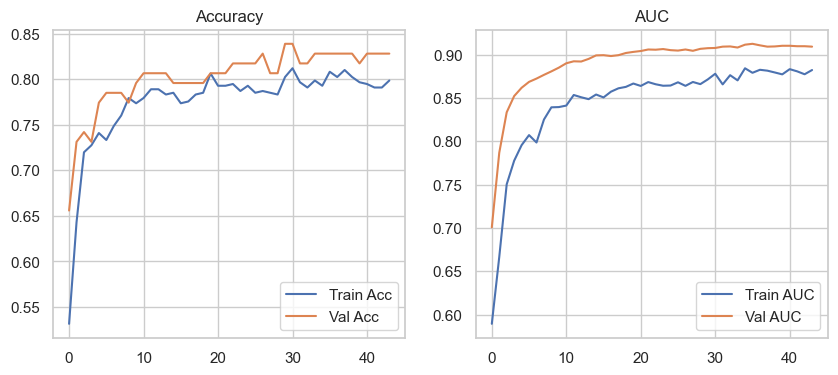

In [7]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Val AUC')
plt.title('AUC')
plt.legend()
plt.show()

### Step 8 - Evaluate model on test data

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
📋 Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.84      0.82       100
           1       0.67      0.61      0.64        54

    accuracy                           0.76       154
   macro avg       0.74      0.73      0.73       154
weighted avg       0.76      0.76      0.76       154

✅ Accuracy:  0.760
🎯 Precision: 0.673
🔁 Recall:    0.611
💡 F1-score:  0.641
🏆 AUC:       0.831


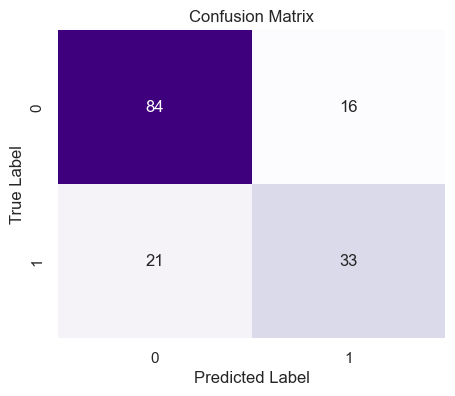

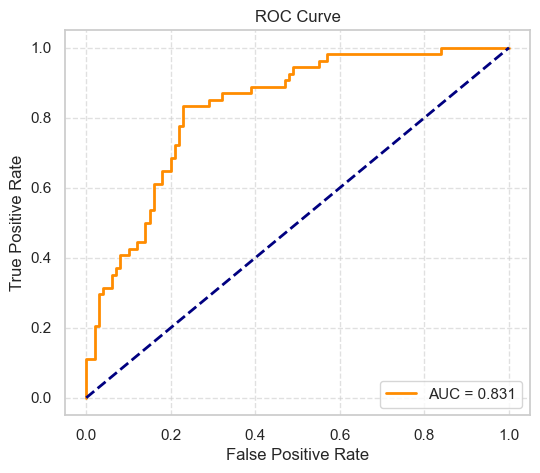

/var/folders/dy/n39312m176q_0131_6rzrpxm0000gn/T/ipykernel_41625/861161974.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Metric', y='Value', data=metrics_df, palette='crest')


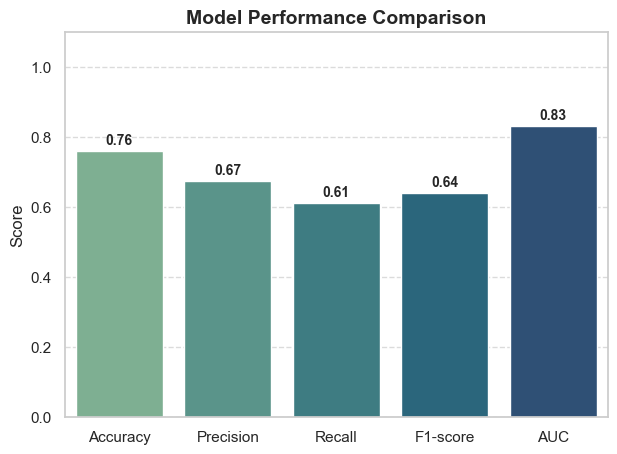

In [8]:
# Predictions
probs = model.predict(X_test).ravel()
preds = (probs >= 0.5).astype(int)

# Metrics
accuracy = np.mean(preds == y_test)
f1 = f1_score(y_test, preds)
precision = precision_score(y_test, preds)
recall = recall_score(y_test, preds)
auc = roc_auc_score(y_test, probs)

print("📋 Classification Report:\n", classification_report(y_test, preds))
print(f"✅ Accuracy:  {accuracy:.3f}")
print(f"🎯 Precision: {precision:.3f}")
print(f"🔁 Recall:    {recall:.3f}")
print(f"💡 F1-score:  {f1:.3f}")
print(f"🏆 AUC:       {auc:.3f}")

cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

fpr, tpr, _ = roc_curve(y_test, probs)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

metrics = {
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1-score": f1,
    "AUC": auc
}

metrics_df = pd.DataFrame(list(metrics.items()), columns=['Metric', 'Value'])
plt.figure(figsize=(7,5))
sns.barplot(x='Metric', y='Value', data=metrics_df, palette='crest')

for i, val in enumerate(metrics_df['Value']):
    plt.text(i, val + 0.01, f"{val:.2f}", ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.ylim(0, 1.1)
plt.title('Model Performance Comparison', fontsize=14, fontweight='bold')
plt.ylabel('Score')
plt.xlabel('')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

The model’s effectiveness can be measured by:
- **Accuracy**
- **Precision & Recall**
- **AUC (Area Under the Curve)**
- **Confusion Matrix**

### Comparison with other algorithms like SVM, Logistic and Random Forest

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "SVM": SVC(kernel='rbf', probability=True),
}

for name, m in models.items():
    m.fit(X_train, y_train)
    preds = m.predict(X_test)
    print(f"{name} Accuracy:", accuracy_score(y_test, preds))

print("Our Model Accuracy:", accuracy)

Logistic Regression Accuracy: 0.7077922077922078
Random Forest Accuracy: 0.7402597402597403
SVM Accuracy: 0.7337662337662337
Our Model Accuracy: 0.7597402597402597


### Step 9 - Save the model and scaler

In [9]:
import joblib

model.save("../models/diabetes_model.keras")
joblib.dump(scaler, "../scaler/diabetes_scaler.pkl")

print("✅ Model and scaler saved successfully!")

✅ Model and scaler saved successfully!


### ✅ Summary

- Built and trained an **Artificial Neural Network (ANN)** for diabetes prediction.  
- Handled missing/zero values using median replacement.  
- Standardized features using `StandardScaler`.  
- Achieved good performance across metrics: **Accuracy, Precision, Recall, F1, and AUC**.  
- Saved the trained model and scaler for Flask integration.

**Visuals included:**
1. Confusion Matrix — clear view of correct vs. wrong predictions  
2. ROC Curve — model’s ability to separate classes  
3. Bar Plot — metric comparison at a glance  
